$$
H = \frac{|p|^2}2 + \gamma \sin(\theta t) s + \frac{\alpha}{|q|}
$$

In [1]:
from integrators import contact as ic
from integrators.common import rk4

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import scipy.integrate as si

plt.style.use('fast') #alt: 'seaborn-white'

#plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'font.weight':'normal'})
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['mathtext.fontset'] = "cm"

In [3]:
class TimePerturbedKepler:
    def __init__(self, gamma, theta, alpha):
        self.θ = theta
        self.α = alpha
        self.γ = gamma

    def f(self, t):
        return self.γ*np.sin(self.θ*t)
    
    def F(self, z, t):
        return self.f(t) * z
    
    def Fprime(self, z, t):
        return self.f(t)

    def V(self, q, t):
        return self.α/np.linalg.norm(q, ord=2)
    
    def Vq(self, q, t):
        return -q*self.α/np.linalg.norm(q, ord=2)**3
    
    def lag(self, q,v,z,t):
        return .5*np.linalg.norm(v)**2 - self.V(q,t) - self.f(t)*z
    
    def lagq(self, q,v,z,t):
        return -self.Vq(q,t)
    
    def lagv(self, q,v,z,t):
        return v
    
    def lagz(self, q,v,z,t):
        return -self.f(t)
    
    def energy(self, p, q, z, t):
        return 0.5*np.linalg.norm(p, ord=2)**2 + self.f(t)*z + self.V(q, t)

In [4]:
def rk4s(system, init, tspan):
    n = len(init)
    def derivs(x, t):
        p = x[:(n-1)//2]
        q = x[(n-1)//2:n-1]
        s = x[-1]
        dp = - system.Vq(q,t) - system.f(t) * p
        dq = p
        ds = system.lag(p, q, s, t)
        return np.concatenate([dp, dq, [ds]])
    return rk4(derivs, init, tspan)

def adaptive(system, init, tspan):
    t_span = (tspan[0], tspan[-1]) 
    n = len(init)
    def derivs(t, x):
        p = x[:(n-1)//2]
        q = x[(n-1)//2:n-1]
        s = x[-1]
        dp = - system.Vq(q,t) - system.f(t) * p
        dq = p
        ds = system.lag(p, q, s, t)
        return np.concatenate([dp, dq, [ds]])
    return si.solve_ivp(derivs, t_span, init, t_eval=tspan, method="Radau", dense_output=True)

In [5]:
e = 0.2
init_ecc = lambda e: [np.array([1.0 - e, 0.0]), np.array([0.0, np.sqrt((1+e)/(1-e))]), np.array([0.0])]
init = init_ecc(e)

energy = lambda pq, z, tspan: np.array([tpk.energy(pq[:,0][i], pq[:,1][i], z[i], t) for i,t in enumerate(tspan)])
save = True

## RK4 comparisons

/opt/local/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-6-84f3f0a40a5c>:77: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


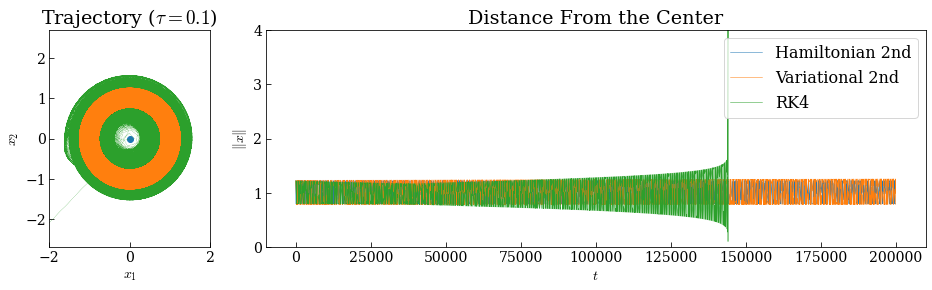

In [6]:
tpk = TimePerturbedKepler(-0.01, np.pi, -1)
dt = 0.1
tf = 200000

tspan = np.arange(0.0, tf, dt)

for (p0, q0, s0) in [init]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    solh, solsh, _ = ic.integrate(ic.step1l, tpk, tspan, p0, q0, s0)
    solv, solsv, _ = ic.integrate(ic.variational_implicit_step, tpk, tspan, p0, q0, s0)
    solrk = rk4s(tpk, np.concatenate([p0,q0,s0]), tspan)
#     r = adaptive(tpk, np.concatenate([p0,q0,s0]), tspan)
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")

    axo.plot(solrk[:,2],
             solrk[:,3],
             ':', linewidth=0.5,
             c='C2',
             label="RK4")
    
    axo.plot(solh[:,1,0],
             solh[:,1,1],
             c='C0',
             linewidth=0.5, label="Hamiltonian 2nd")
    
    axo.plot(solv[:,1,0],
             solv[:,1,1],
             c='C1',
             linewidth=0.5, label="Variational 2nd")
    
#     axo.plot(r.y[:,2],
#              r.y[:,3],
#              ':', linewidth=0.5,
#              c='C3',
#              label="Reference")

    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)

    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")

    #axo.legend(loc='lower left')
    
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")
    
    axe.plot(tspan,
             np.linalg.norm(solh[:,1], axis=1),
             linewidth=0.5, label="Hamiltonian 2nd")
    axe.plot(tspan,
             np.linalg.norm(solv[:,1], axis=1),
             linewidth=0.5, label="Variational 2nd")
    axe.plot(tspan,
             np.linalg.norm(solrk[:, 2:4], axis=1),
             linewidth=0.5, label="RK4")
#     axe.plot(tspan,
#              np.linalg.norm(r.y.T[:, 2:4], axis=1),
#              linewidth=0.5, label="Reference")
    
    axe.set_ylim(0, 4)
    axe.legend(loc='upper right')

    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")
    
    if save:
        fig.savefig(f"images/TPK01.pdf", bbox_inches='tight')
    fig.show()

/opt/local/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<ipython-input-7-f8ff754ca476>:77: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


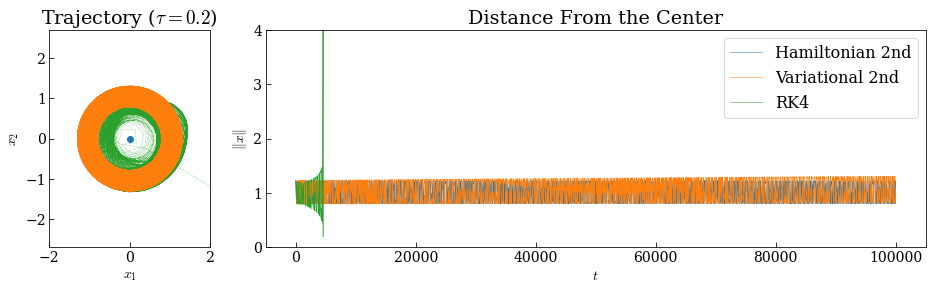

In [7]:
tpk = TimePerturbedKepler(-0.01, np.pi, -1)
dt = 0.2
tf = 100000

tspan = np.arange(0.0, tf, dt)

for (p0, q0, s0) in [init]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    solh, solsh, _ = ic.integrate(ic.step1l, tpk, tspan, p0, q0, s0)
    solv, solsv, _ = ic.integrate(ic.variational_implicit_step, tpk, tspan, p0, q0, s0)
    solrk = rk4s(tpk, np.concatenate([p0,q0,s0]), tspan)
#     r = adaptive(tpk, np.concatenate([p0,q0,s0]), tspan)
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")

    axo.plot(solrk[:,2],
             solrk[:,3],
             ':', linewidth=0.5,
             c='C2',
             label="RK4")
    
    axo.plot(solh[:,1,0],
             solh[:,1,1],
             c='C0',
             linewidth=0.5, label="Hamiltonian 2nd")
    
    axo.plot(solv[:,1,0],
             solv[:,1,1],
             c='C1',
             linewidth=0.5, label="Variational 2nd")
    
#     axo.plot(r.y[:,2],
#              r.y[:,3],
#              ':', linewidth=0.5,
#              c='C3',
#              label="Reference")

    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)

    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")

    #axo.legend(loc='lower left')
    
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")
    
    axe.plot(tspan,
             np.linalg.norm(solh[:,1], axis=1),
             linewidth=0.5, label="Hamiltonian 2nd")
    axe.plot(tspan,
             np.linalg.norm(solv[:,1], axis=1),
             linewidth=0.5, label="Variational 2nd")
    axe.plot(tspan,
             np.linalg.norm(solrk[:, 2:4], axis=1),
             linewidth=0.5, label="RK4")
#     axe.plot(tspan,
#              np.linalg.norm(r.y.T[:, 2:4], axis=1),
#              linewidth=0.5, label="Reference")
    
    axe.set_ylim(0, 4)
    axe.legend(loc='upper right')

    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")
    
    if save:
        fig.savefig(f"images/TPK02.pdf", bbox_inches='tight')
    fig.show()

<ipython-input-8-709a941b726a>:77: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


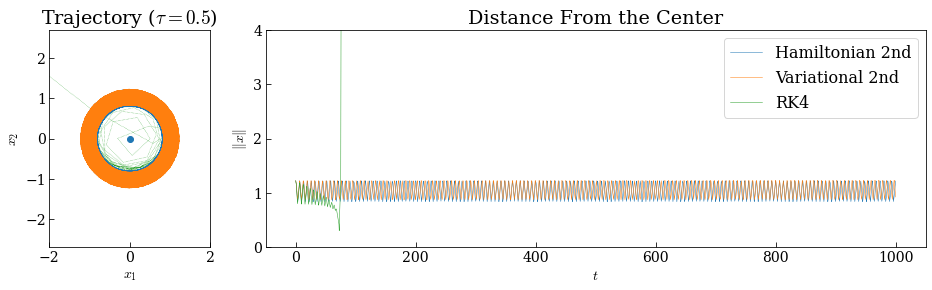

In [8]:
tpk = TimePerturbedKepler(-0.01, np.pi, -1)
dt = 0.5
tf = 1000

tspan = np.arange(0.0, tf, dt)

for (p0, q0, s0) in [init]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    solh, solsh, _ = ic.integrate(ic.step1l, tpk, tspan, p0, q0, s0)
    solv, solsv, _ = ic.integrate(ic.variational_implicit_step, tpk, tspan, p0, q0, s0)
    solrk = rk4s(tpk, np.concatenate([p0,q0,s0]), tspan)
#     r = adaptive(tpk, np.concatenate([p0,q0,s0]), tspan)
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")

    axo.plot(solrk[:,2],
             solrk[:,3],
             ':', linewidth=0.5,
             c='C2',
             label="RK4")
    
    axo.plot(solh[:,1,0],
             solh[:,1,1],
             c='C0',
             linewidth=0.5, label="Hamiltonian 2nd")
    
    axo.plot(solv[:,1,0],
             solv[:,1,1],
             c='C1',
             linewidth=0.5, label="Variational 2nd")
    
#     axo.plot(r.y[:,2],
#              r.y[:,3],
#              ':', linewidth=0.5,
#              c='C3',
#              label="Reference")

    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)

    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")

    #axo.legend(loc='lower left')
    
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")
    
    axe.plot(tspan,
             np.linalg.norm(solh[:,1], axis=1),
             linewidth=0.5, label="Hamiltonian 2nd")
    axe.plot(tspan,
             np.linalg.norm(solv[:,1], axis=1),
             linewidth=0.5, label="Variational 2nd")
    axe.plot(tspan,
             np.linalg.norm(solrk[:, 2:4], axis=1),
             linewidth=0.5, label="RK4")
#     axe.plot(tspan,
#              np.linalg.norm(r.y.T[:, 2:4], axis=1),
#              linewidth=0.5, label="Reference")
    
    axe.set_ylim(0, 4)
    axe.legend(loc='upper right')

    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")
    
    if save:
        fig.savefig(f"images/TPK05.pdf", bbox_inches='tight')
    fig.show()

<ipython-input-9-c3ac733e84ce>:90: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


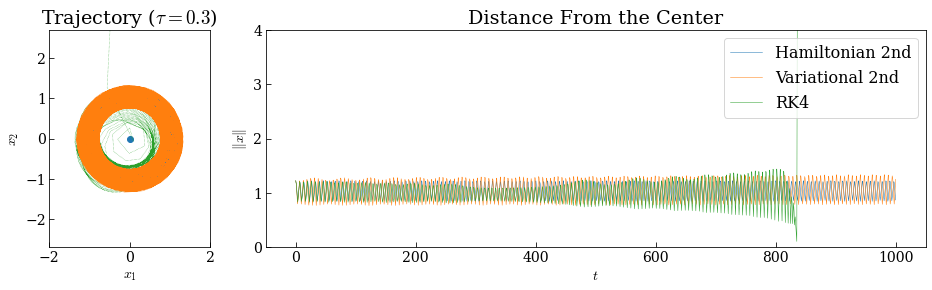

In [9]:
tpk = TimePerturbedKepler(-0.05, np.pi, -1)
dt = 0.3
tf = 1000

tspan = np.arange(0.0, tf, dt)
steps=len(tspan)

tspan = np.arange(0.0, tf, dt)

for (p0, q0, s0) in [init]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    solh, solsh, _ = ic.integrate(ic.step1l, tpk, tspan, p0, q0, s0)
    solv, solsv, _ = ic.integrate(ic.variational_implicit_step, tpk, tspan, p0, q0, s0)
#     sol6, sol6s, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, s0)
    solrk = rk4s(tpk, np.concatenate([p0,q0,s0]), tspan)
#     r = adaptive(tpk, np.concatenate([p0,q0,s0]), tspan)
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")

    axo.plot(solrk[:,2],
             solrk[:,3],
             ':', linewidth=0.5,
             c='C2',
             label="RK4")
    
    axo.plot(solh[:,1,0],
             solh[:,1,1],
             c='C0',
             linewidth=0.5, label="Hamiltonian 2nd")
    
    axo.plot(solv[:,1,0],
             solv[:,1,1],
             c='C1',
             linewidth=0.5, label="Variational 2nd")
    
#     axo.plot(sol6[:,1,0],
#              sol6[:,1,1],
#              c='C4',
#              linewidth=0.5, label="Hamiltonian 6th")
    
#     axo.plot(r.y[:,2],
#              r.y[:,3],
#              ':', linewidth=0.5,
#              c='C3',
#              label="Reference")

    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)

    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")

    #axo.legend(loc='lower left')
    
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")
    
    axe.plot(tspan,
             np.linalg.norm(solh[:,1], axis=1),
             linewidth=0.5, label="Hamiltonian 2nd")
    axe.plot(tspan,
             np.linalg.norm(solv[:,1], axis=1),
             linewidth=0.5, label="Variational 2nd")
    axe.plot(tspan,
             np.linalg.norm(solrk[:, 2:4], axis=1),
             linewidth=0.5, label="RK4")
#     axe.plot(tspan,
#              np.linalg.norm(r.y.T[:, 2:4], axis=1),
#              linewidth=0.5, label="Reference")
#     axe.plot(tspan,
#              np.linalg.norm(sol6[:,1], axis=1),
#              c='C4',
#              linewidth=0.5, label="Hamiltonian 6th")
    
    axe.set_ylim(0, 4)
    axe.legend(loc='upper right')

    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")
    
    if save:
        fig.savefig(f"images/TPK03prec.pdf", bbox_inches='tight')
    fig.show()

<ipython-input-11-014524cf76bf>:90: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


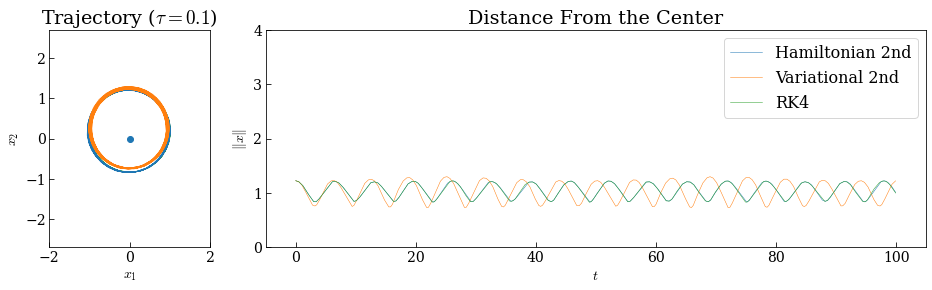

In [11]:
tpk = TimePerturbedKepler(-0.05, np.pi, -1)
dt = 0.1
tf = 100

tspan = np.arange(0.0, tf, dt)
steps=len(tspan)

tspan = np.arange(0.0, tf, dt)

for (p0, q0, s0) in [init]:
    fig = plt.figure(figsize=(16,4))
    gs = matplotlib.gridspec.GridSpec(1, 4, figure=fig)
    
    solh, solsh, _ = ic.integrate(ic.step1l, tpk, tspan, p0, q0, s0)
    solv, solsv, _ = ic.integrate(ic.variational_implicit_step, tpk, tspan, p0, q0, s0)
#     sol6, sol6s, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, s0)
    solrk = rk4s(tpk, np.concatenate([p0,q0,s0]), tspan)
#     r = adaptive(tpk, np.concatenate([p0,q0,s0]), tspan)
    
    axo = fig.add_subplot(gs[0,0])
    axo.set_title(f"Trajectory ($\\tau={dt}$)")

    axo.plot(solrk[:,2],
             solrk[:,3],
             ':', linewidth=0.5,
             c='C2',
             label="RK4")
    
    axo.plot(solh[:,1,0],
             solh[:,1,1],
             c='C0',
             linewidth=0.5, label="Hamiltonian 2nd")
    
    axo.plot(solv[:,1,0],
             solv[:,1,1],
             c='C1',
             linewidth=0.5, label="Variational 2nd")
    
#     axo.plot(sol6[:,1,0],
#              sol6[:,1,1],
#              c='C4',
#              linewidth=0.5, label="Hamiltonian 6th")
    
#     axo.plot(r.y[:,2],
#              r.y[:,3],
#              ':', linewidth=0.5,
#              c='C3',
#              label="Reference")

    axo.scatter(0,0)
    
    axo.set_aspect('equal', adjustable='box')
    
    axo.set_xlim(-2, 2)
    axo.set_ylim(-2.7, 2.7)

    axo.set_xlabel("$x_1$")
    axo.set_ylabel("$x_2$")

    #axo.legend(loc='lower left')
    
    axe = fig.add_subplot(gs[0,1:])
    axe.set_title("Distance From the Center")
    
    axe.plot(tspan,
             np.linalg.norm(solh[:,1], axis=1),
             linewidth=0.5, label="Hamiltonian 2nd")
    axe.plot(tspan,
             np.linalg.norm(solv[:,1], axis=1),
             linewidth=0.5, label="Variational 2nd")
    axe.plot(tspan,
             np.linalg.norm(solrk[:, 2:4], axis=1),
             linewidth=0.5, label="RK4")
#     axe.plot(tspan,
#              np.linalg.norm(r.y.T[:, 2:4], axis=1),
#              linewidth=0.5, label="Reference")
#     axe.plot(tspan,
#              np.linalg.norm(sol6[:,1], axis=1),
#              c='C4',
#              linewidth=0.5, label="Hamiltonian 6th")
    
    axe.set_ylim(0, 4)
    axe.legend(loc='upper right')

    axe.set_xlabel("$t$")
    axe.set_ylabel("$\|x\|$")
    
    if save:
        fig.savefig(f"images/TPK03prec.pdf", bbox_inches='tight')
    fig.show()